In [2]:
import sys


# os.environ['R_LIBS_USER'] = '/project/projectdirs/metatlas/r_pkgs/'

# sys.path.insert(0, '/project/projectdirs/metatlas/python_pkgs/')
sys.path.insert(0,'/global/project/projectdirs/metatlas/anaconda/lib/python2.7/site-packages' )

from metatlas import metatlas_objects as metob
from metatlas import h5_query as h5q
from metatlas import gui as mgui

import qgrid
#import metatlas_get_data_helper_fun as ma_data
import pandas as pd
import os
import tables
import pickle

%matplotlib notebook


In [ ]:
# lcms_files = metob.retrieve('Lcmsrun', mzml_file = '%_SJ_%BEMC%',username='*')
# print len(lcms_files)
# metob.edit_objects(lcms_files)

In [3]:
mgui.show_experiments()

[{'creation_time': '2015-09-19T21:33:26',
 'description': u'20141211_Actinorhodin 20141211_MeOHBlank_C18_POS_MSMS_ACN_mid_9.mzML',
 'experiment': u'20141211_Actinorhodin',
 'hdf5_file': u'/project/projectdirs/metatlas/raw_data/kblouie/20141211_Actinorhodin/20141211_MeOHBlank_C18_POS_MSMS_ACN_mid_9.h5',
 'head_id': u'06f898a682ea45779b1a309570d19bfa',
 'injection_volume': 0.0,
 'injection_volume_units': 'xx',
 'last_modified': '2015-12-13T09:50:20',
 'method': None,
 'mzml_file': u'/project/projectdirs/metatlas/raw_data/kblouie/20141211_Actinorhodin/20141211_MeOHBlank_C18_POS_MSMS_ACN_mid_9.mzML',
 'name': u'20141211_MeOHBlank_C18_POS_MSMS_ACN_mid_9.mzML',
 'prev_uid': u'd79a27dfec814c25a12a49d90e80ab88',
 'sample': None,
 'unique_id': u'06f898a682ea45779b1a309570d19bfa',
 'username': u'kblouie'}, {'creation_time': '2015-09-19T21:33:26',
 'description': u'20141211_Actinorhodin 20141211_MeOHBlank_C18_POS_MSMS_ACN_mid_60.mzML',
 'experiment': u'20141211_Actinorhodin',
 'hdf5_file': u'/pro

In [16]:
# f = '/global/project/projectdirs/metatlas/raw_data/tls/20150920_TS_BSCporewater_neg_6550/150920_TS_neg_19B_49h.h5'
# with tables.open_file(f) as fid:
#     data = h5q.get_data(fid,ms_level=1,polarity = 0)    

In [4]:
data

NameError: name 'data' is not defined

In [5]:
#Select the group
# group = metob.retrieve('Groups', name = '%LS_Archetypes%hilic%neg%')
temp_group = metob.retrieve('Groups', name = '%20160203_KBL-BC_Root-Exudate_Hilic_QExactive_Trial-Run_POS%',username='*')
# temp_group = metob.retrieve('Groups', name = '%Replicate_Analysis_R2A_HILIC_neg%')
print temp_group
group = []
for i,g in enumerate(temp_group):
    if len(g.items) > 0:
        group.append(g)

# group = metob.retrieve('Groups',name='%Avena_Hopland%RootCass%_neg')
# group = metob.retrieve('Groups',name='%Avena_Hopland%RootCass%_pos')
# group = metob.retrieve('Groups',name='%Avena_Hopland%RootExu%')
# group = metob.retrieve('Groups',name='%Avena_Hopland%RootExu%_pos')
# group = metob.retrieve('Groups',name='%Avena_Hopland%RootExu%_neg')

mgui.edit_objects(group)

[]


In [6]:
#Select the atlas
# atlas = metob.retrieve('Atlas',name = '%_Hilic_QExactive_AvenaExudates_2%')
# atlas = metob.retrieve('Atlas',name = '%_Positive%_Hilic_QExactive_AvenaExudates_2%')
# atlas = metob.retrieve('Atlas',name = '%_Negative%_Hilic_QExactive_AvenaExudates_2%')
# atlas = metob.retrieve('Atlas',name = '%internal standards%')
atlas = metob.retrieve('Atlas',name = '%_KZ_%',username='*')#_Archetypes_ISTDs%')
# 20151130_LS_Positive_Hilic_QExactive_Archetypes_ISTDs
# 20151130_LS_Negative_Hilic_QExactive_Archetypes_ISTDs
# mgui.edit_objects(atlas)
len(atlas)
# atlas

12

In [9]:
print atlas[11]

{'compound_identifications': [Compoundidentifications cd052496a1b342b6a89e0f1b231dc531,
                              Compoundidentifications a1d98cb440fc41c8b21b1c2e2a5a8cfe,
                              Compoundidentifications 9ca605a89f5742fca80b31a8ced55ffb,
                              Compoundidentifications 3400dcf9276f4ad887022a8a9ee36a5e,
                              Compoundidentifications f451ad65ffd548c786cc534e86b8628f,
                              Compoundidentifications b03c5d8d056642b897aca6ad717d78fa,
                              Compoundidentifications e57b99686b084969ac9329c6800f53d4,
                              Compoundidentifications 23c6b97708a748868df17d2593c72c1a,
                              Compoundidentifications 790cb02229dd4166b9e525838d418486,
                              Compoundidentifications aa09bfca2312463a9da914b198d0683a,
                              Compoundidentifications 2a9b167811014dae82e8e2b8e56449ca,
                              Co

In [9]:
# myAtlases = [atlas[0],atlas[1]] #concatenate the atlases you want to use
# myAtlases = [atlas[0]]
myAtlas = [atlas[0]]
compound_list = []
for i in range(len(myAtlas[0].compound_identifications)):
    compound_list.append(myAtlas[0].compound_identifications[i].compound[0].name)

cols = ['inchi',
 'mono_isotopic_molecular_weight',
 'creation_time',
 'description',
 'formula',
 'functional_sets',
 'last_modified',
 'reference_xrefs',
 'synonyms',
 'unique_id',
 'url',
 'username']
    
    # print myAtlas[0].compound_identifications[0].compound
atlas_export = pd.DataFrame( index=compound_list, columns=cols)

atlas_export['name'] = compound_list
atlas_export.set_index('name',drop=True)
for i in range(len(myAtlas[0].compound_identifications)):
    n = myAtlas[0].compound_identifications[i].compound[0].name
    for c in cols:
        g = getattr(myAtlas[0].compound_identifications[i].compound[0],c)
        if g:
            atlas_export.ix[n,c] = getattr(myAtlas[0].compound_identifications[i].compound[0],c)
    atlas_export.ix[n,'rt_min'] = myAtlas[0].compound_identifications[i].rt_references[0].rt_min
    atlas_export.ix[n,'rt_max'] = myAtlas[0].compound_identifications[i].rt_references[0].rt_max
    atlas_export.ix[n,'rt_peak'] = myAtlas[0].compound_identifications[i].rt_references[0].rt_peak
    atlas_export.ix[n,'mz'] = myAtlas[0].compound_identifications[i].mz_references[0].mz
    atlas_export.ix[n,'mz_tolerance'] = myAtlas[0].compound_identifications[i].mz_references[0].mz_tolerance
atlas_export.to_csv('arkin.csv')
# for d in data:
#     c = d[2]
#     f = d[4]
#     if len(d[1])>0:
#         v = max(d[1])
#     else:
#         v = 0
#     peak_height.ix[c,f] = v

AttributeError: 'Stub' object has no attribute 'compound'

In [11]:
myAtlas[0].compound_identifications[i].rt_references[0].rt_min
myAtlas[0].compound_identifications[i].rt_references[0].rt_max
myAtlas[0].compound_identifications[i].rt_references[0].rt_peak
myAtlas[0].compound_identifications[i].mz_references[0]
myAtlas[0].compound_identifications[i].mz_references[0].mz
myAtlas[0].compound_identifications[i].mz_references[0].mz_tolerance

5.0

In [23]:
myAtlases = [atlas[-2]]

In [24]:
print myAtlases[0].name
print myAtlases[0].compound_identifications[0].compound[0].name
myAtlases[0].compound_identifications[0].mz_references
# print myAtlases[0].compound_identifications[0].references[0].mz
# print myAtlases[0].compound_identifications[0].references[0].mz_tolerance
# print myAtlases[0].compound_identifications[0].rt_references[0].rt_min
# print myAtlases[0].compound_identifications[0].rt_references[0].rt_max
# print myAtlases[0].compound_identifications[0].rt_references[0].rt_peak
# print myAtlases[0].compound_identifications[0].rt_references[0].rt_units

# print myAtlases[0].compound_identifications[0].references[1].RTmax
# print myAtlases[0].compound_identifications[0].references[1].RTpeak
# a = atlas.compound_identifications[0]
# a.description

20151023_KZ_Positive_Hilic_QExactive_AvenaExudates_2
2-aminoisobutyrate


[{'adduct': u'[M+H]+',
  'creation_time': '2015-11-23T19:36:35',
  'description': u'No description',
  'detected_polarity': 'positive',
  'enabled': True,
  'head_id': u'80388a8b05214d51ab3247ff9fac1c4a',
  'last_modified': '2015-11-23T19:36:35',
  'lcms_run': None,
  'modification': u'',
  'mz': 104.0706045,
  'mz_tolerance': 10.0,
  'mz_tolerance_units': 'ppm',
  'name': u'Untitled',
  'observed_formula': u'',
  'prev_uid': u'origin',
  'ref_type': u'',
  'unique_id': u'80388a8b05214d51ab3247ff9fac1c4a',
  'username': u'bpb'}]

In [6]:
# print len(allcompounds)
# print allcompounds[0]
# print allcompounds[1]
# compound_list = []
# for c in allcompounds:
#     compound_list.append(c['name'])
# dataCols = ['mzmin','mzmax','rtmin','rtmax']
# myAtlas = pd.DataFrame( index=compound_list, columns=dataCols, dtype=float)

# for c in allcompounds:
#     for d in dataCols:
#         myAtlas.ix[c['name'],d] = c[d]
# qgrid.show_grid(myAtlas)

In [9]:
# print myreferences[0].compound[0].name
# print myreferences[0].references[0].mz
# print myreferences[0].references[1].RTpeak

In [ ]:
# get and pickle everything This is MSMS, raw MS1 datapoints, compound, group info, and file info
# combine positive and negative mode atlas, by join atlases together vs two compound references
# typically file-groups are NOT split by polarity, files with un-matched polarity will be discarded for analysis of an identification
from metatlas import h5_query as h5q
import os
import tables
import dill
ma_data = reload(ma_data)
data = []
for i,treatment_groups in enumerate(group):
    for j in range(len(treatment_groups.items)):
        myFile = treatment_groups.items[j].hdf5_file
        print i,myFile
        row = []
        for atlas in myAtlases:
            for compound in atlas.compound_identifications:
                result = {}
                result['lcmsrun'] = treatment_groups.items[j] #.unique_id
                result['group'] = treatment_groups #.unique_id
#                 result['atlas'] = atlas.unique_id
                result['identification'] = compound #.unique_id
                result['data'] = ma_data.get_data_for_a_compound(compound.mz_references[0],
                                        compound.rt_references[0],
                                        [ 'ms1_summary', 'eic', 'msms' ],
                                        myFile,0.3)
#                 print result['data']['ms1_summary']
                row.append(result)
        data.append(row)
with open('20160203_KBL-BC_Root-Exudate_Hilic_QExactive_Trial-Run_POS.pkl','w') as f:
    dill.dump(data,f)

In [7]:
data[0][0]['data']

{'eic': {'intensity': array([  1.29519736e+04,   2.42093789e+04,   2.49738125e+04,
           3.11992812e+04,   3.15344688e+04,   6.35300391e+04,
           8.90617969e+04,   1.10729250e+05,   1.17598562e+05,
           6.68327500e+04,   9.95365625e+04,   8.34206250e+04,
           8.91792500e+04,   6.28883125e+04,   8.48820625e+04,
           8.49846250e+04,   8.58570000e+04,   8.59568750e+04,
           1.07759625e+05,   1.08285750e+05,   1.19434250e+05,
           1.40532250e+05,   1.44119500e+05,   1.54220750e+05,
           1.50184250e+05,   1.44659000e+05,   1.26636750e+05,
           1.25226000e+05,   1.16083250e+05,   1.07779000e+05,
           1.04105250e+05,   7.25500000e+04,   5.49607500e+04,
           2.73907500e+04,   2.12835000e+04,   1.70222500e+04,
           1.94332500e+04,   1.48000000e+04,   1.06090000e+04,
           1.05970000e+04,   6.95600000e+03,   9.98125000e+03,
           6.26800000e+03,   2.88975000e+03,   7.12400000e+03,
           2.86575000e+03,   2.5377

In [12]:

# result['identification']

In [25]:
# file_column_name = []
# group_column_name = []
# for i,treatment_groups in enumerate(group):
#     for j in range(len(treatment_groups.items)):
#         myFile = treatment_groups.items[j].hdf5_file
#         file_column_name.append(os.path.basename(myFile))
#         group_column_name.append(treatment_groups.name)
# # print file_column_name
# # print group_column_name
# compound_list = []
# for compound in atlas.compound_identifications[:3]:
#     compound_list.append(compound.compound[0].name)

In [24]:
# # column name list
# # row name list
# import pandas as pd
# import os
# peak_height = pd.DataFrame( index=compound_list, columns=file_column_name, dtype=float)
# # peak_height['compound'] = compound_list
# # peak_height.set_index('compound',drop=True)
# for d in data:
#     c = d[2]
#     f = d[4]
#     if len(d[1])>0:
#         v = max(d[1])
#     else:
#         v = 0
#     peak_height.ix[c,f] = v
    
# peak_area = pd.DataFrame( index=compound_list, columns=file_column_name, dtype=float)
# # peak_height['compound'] = compound_list
# # peak_height.set_index('compound',drop=True)
# for d in data:
#     c = d[2]
#     f = d[4]
#     if len(d[1])>0:
#         v = sum(d[1])
#     else:
#         v = 0
#     peak_area.ix[c,f] = v

In [13]:
# qgrid.show_grid(peak_height)

//anaconda/lib/python2.7/site-packages/pandas/core/internals.py:956: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  return self._try_coerce_result(func(values, other))


In [19]:
# columns = []
# for i,f in enumerate(file_column_name):
#     columns.append((group_column_name[i],f))
# peak_height.columns = pd.MultiIndex.from_tuples(columns,names=['group', 'file'])
# peak_area.columns = pd.MultiIndex.from_tuples(columns,names=['group', 'file'])

NameError: name 'file_column_name' is not defined

In [18]:
# m = peak_height.groupby(axis=1,level='group').mean()
# qgrid.show_grid(m)


NameError: name 'peak_height' is not defined

<IPython.core.display.Javascript object>


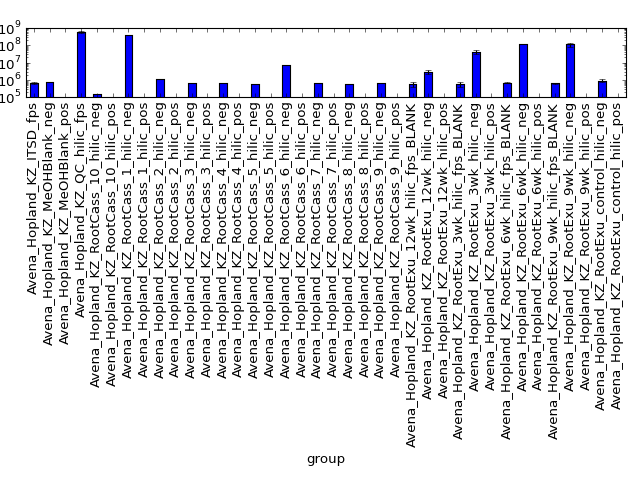

In [26]:
# from matplotlib import pyplot as plt

# m = peak_height.ix['adenine'].groupby(level='group').mean()
# e = peak_height.ix['adenine'].groupby(level='group').std()
# c = peak_height.ix['adenine'].groupby(level='group').count()

# for i in range(len(e)):
#     if c[i]>0:
#         e[i] = e[i] / c[i]**0.5

# fig, ax = plt.subplots()
# m.plot(yerr=e, kind='bar')
# plt.tight_layout()
# a = plt.gca()
# a.set_yscale('log')
# plt.show()


In [27]:

# peak_height.to_csv('compounds neg peak height.tab',sep='\t')
# peak_area.to_csv('compounds neg peak area.tab',sep='\t')

In [17]:
# df=pd.DataFrame({'a':[1,2,3],'b':[4,5,6]})

# columns=[('c','a'),('c','b')]

# df.columns=pd.MultiIndex.from_tuples(columns)
# df

c   
   a  b
0  1  4
1  2  5
2  3  6

In [73]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [74]:
import os
filename = os.path.basename(NOTEBOOK_FULL_PATH)
%system cp $filename /project/projectdirs/openmsi/www/
temp = '%s/%s'%('/project/projectdirs/openmsi/www',filename)
%system chmod 775 $temp
print 'http://nbviewer.ipython.org/url/portal.nersc.gov/project/openmsi/%s?flush_cache=true'%filename

http://nbviewer.ipython.org/url/portal.nersc.gov/project/openmsi/Get a Group of Files and Atlas and Get Data.ipynb?flush_cache=true


In [ ]:
# helpful pandas hints for commands
# df
# print df.keys()
# df.loc[0,'name']
# df.filter(regex = 'name')
# df.iloc[0]
# for x in df.index:
#     print df.name[x]
#     if not metob.retrieve('Compounds',name=df.name[x]):
#         print df.name[x], "is not in database"
#     else:
#         print df.name[x], "Success"

#         
#     df = df.append(data)
#     print df.iloc[x,0]
#     print df.iloc[x]
#     print df.name[x]
# df.ix[(df['name']=='Adenine') == True]['mz']
# df.ix[(df['name']=='Adenine') == True]
# df.name.str.contains('Ad')
# df.name.str.contains('Ad').tolist()
# df

In [15]:
# files = metob.retrieve('lcmsrun',name='%Actino%')
import numpy as np
my_run = metob.retrieve('lcmsrun', hdf5_file='%20150510_C18_POS_MSMS_HE08-3%', username='*')
my_run
# for f in files:
#     print f.hdf5_file
with tables.open_file(my_run[0].hdf5_file) as fid:
    data = h5q.get_data(fid,2,1,min_rt = 2.1)#,max_rt = 17.9,min_precursor_MZ=633.12,max_precursor_MZ = 633.2)
print data['rt']
prt,pmz = get_unique_scan_data(data)
rt_cutoff = 0.23
mz_cutoff = 0.05
list_of_prt,list_of_pmz = get_non_redundant_precursor_list(prt,pmz,rt_cutoff,mz_cutoff)
#setup data format for searching
pactolus_input = {}
pactolus_input['spectra'] = []
pactolus_input['precursor_mz'] = []
for i,(prt,pmz) in enumerate(zip(list_of_prt,list_of_pmz)):
    idx = np.argwhere((data['precursor_MZ'] == pmz) & (data['rt'] == prt )).flatten()
    arr = np.array([data['mz'][idx], data['i'][idx]]).T
    pactolus_input['spectra'].append(arr)
    pactolus_input['precursor_mz'].append(pmz)
    


[  2.104074    2.104074    2.104074  ...,  11.5003891  11.5003891
  11.5003891]


In [20]:
import glob

# curr_ld_lib_path = ''
# os.environ['LD_LIBRARY_PATH'] = curr_ld_lib_path + ':/project/projectdirs/openmsi/jupyterhub_libs/boost_1_55_0/lib' + ':/project/projectdirs/openmsi/jupyterhub_libs/lib'
import sys
# sys.path.remove('/anaconda/lib/python2.7/site-packages')
sys.path.append('/global/project/projectdirs/openmsi/jupyterhub_libs/anaconda/lib/python2.7/site-packages')

# sys.path.insert(0,'/global/project/projectdirs/metatlas/anaconda/lib/python2.7/site-packages' )


sys.path.append('/project/projectdirs/openmsi/projects/meta-iq/pactolus/pactolus')

import score_frag_dag


pos_mode_neutralizations = [-1.00727646677, -(1.00727646677+1.00782504), +5.4857990946e-4,]
neg_mode_neutralizations = [-el for el in pos_mode_neutralizations]

# make lookup table
# path_to_trees = '/project/projectdirs/openmsi/projects/pactolus_trees/'
# all_my_h5_files = glob.glob('/project/projectdirs/openmsi/projects/pactolus_trees/*_hdf5_5_*.h5')

path_to_trees = '/project/projectdirs/openmsi/projects/ben_trees/'
all_my_h5_files = glob.glob('/project/projectdirs/openmsi/projects/ben_trees/*_hdf5_5_*.h5')

my_tree_filename = 'metacyc_max_depth_5'

if not os.path.isfile(os.path.join(path_to_trees, my_tree_filename + '.npy')):
    score_frag_dag.make_file_lookup_table_by_MS1_mass(all_my_h5_files, 
                                                      path=path_to_trees, 
                                                      save_result='metacyc_max_depth_5')

maxdepth_5_table = os.path.join(path_to_trees, my_tree_filename + '.npy')

params = {'file_lookup_table': maxdepth_5_table,
          'ms1_mass_tol': 0.05,
          'ms2_mass_tol': 0.05,
          'neutralizations': pos_mode_neutralizations,
          'max_depth': 5,
              }



In [21]:
print len(pactolus_input['spectra'])

580


In [39]:
import time

for i in range(10):
    start = time.time()
    foo = score_frag_dag.score_scan_list_against_trees([pactolus_input['spectra'][i]], [pactolus_input['precursor_mz'][i]], params)
    stop = time.time()
    print stop - start, np.sum(foo>0)
# np.argmax(foo)

0.00915908813477 0
0.225470066071 31
13.8581519127 24
0.199229955673 29
0.205362796783 13
0.293752908707 37
1.79723000526 133
0.200758218765 28
0.278684139252 48
0.00717997550964 0


In [27]:
metatlas_molecules = np.load(maxdepth_5_table)

In [33]:
metatlas_molecules.shape

(13190,)

In [25]:
foo.shape

(5, 13190)

In [ ]:
my_db = '/project/projectdirs/openmsi/projects/meta-iq/pactolus/data/' + 'MetaCyc.mdb'
pactolus_results = score_frag_dag.make_pactolus_hit_table(foo, maxdepth_5_table, original_db=my_db)

In [ ]:
for r in pactolus_results:
    if len(r)>0:
        print r[0]